# So sánh hiệu suất giữa OpenAI GPT-4o và Grok

Notebook này so sánh hiệu suất của hai mô hình LLM:
- **OpenAI GPT-4o**: Sử dụng function calling và structured outputs
- **Grok (X.AI)**: Sử dụng API requests với JSON parsing

Các kỹ thuật prompting được so sánh:
1. **Zero-shot**: Không có ví dụ
2. **Chain-of-Thought (CoT)**: Tư duy từng bước
3. **Few-shot Clustering**: Chọn ví dụ dựa trên clustering

In [14]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

In [15]:
# Đường dẫn tới thư mục results
RESULT_DIR = Path(r"c:\Users\Admin\Python\ABSA_Prompting\results")
DATA_DIR = Path(r"c:\Users\Admin\Python\ABSA_Prompting\data")

# Đọc dữ liệu test để tính toán metrics
test_file = DATA_DIR / 'ViABSA_BP' / 'data_test.csv'
test_df = pd.read_csv(test_file)

In [16]:
def transform_aspect_sentiment(df, start=0, end=None):
    """Chuyển đổi DataFrame thành format chuẩn để đánh giá"""
    aspects = [
        "stayingpower",
        "texture", 
        "smell",
        "price",
        "others",
        "colour",
        "shipping",
        "packing"
    ]

    if end is None:
        end = len(df)

    result = []

    for idx, row in df.iloc[start:end].iterrows():
        entry = {
            "id": str(idx),
            "text": row['data'],
            "sentiments": []
        }

        for aspect in aspects:
            sentiment = row[f"{aspect}_label"]
            if sentiment == 1:  # chỉ lấy những cái có sentiment
                aspect_sentiment_value = row[aspect]
                if aspect_sentiment_value != 'none':
                    entry["sentiments"].append({
                        "aspect": aspect,
                        "sentiment": aspect_sentiment_value
                    })
                else:
                    entry["sentiments"].append({
                        "aspect": aspect,
                        "sentiment": "unknown"
                    })

        result.append(entry)

    return result

In [17]:
def evaluate_aspect_sentiment(ground_truth, predictions):
    """Đánh giá hiệu suất aspect detection và sentiment classification"""
    true_aspects = []
    pred_aspects = []
    true_aspect_sentiments = []
    pred_aspect_sentiments = []

    for gt_entry, pred_entry in zip(ground_truth, predictions):
        # Ground truth
        gt_sents = gt_entry['sentiments']
        gt_aspect_set = set()
        gt_aspect_sentiment_set = set()

        for item in gt_sents:
            gt_aspect_set.add(item['aspect'])
            gt_aspect_sentiment_set.add((item['aspect'], item['sentiment']))

        true_aspects.append(gt_aspect_set)
        true_aspect_sentiments.append(gt_aspect_sentiment_set)

        # Predictions
        pred_sents = pred_entry.get('results', [])
        pred_aspect_set = set()
        pred_aspect_sentiment_set = set()

        for item in pred_sents:
            pred_aspect_set.add(item['aspect'])
            pred_aspect_sentiment_set.add((item['aspect'], item['sentiment']))

        pred_aspects.append(pred_aspect_set)
        pred_aspect_sentiments.append(pred_aspect_sentiment_set)

    # Tính micro-F1 cho aspect detection
    tp_aspect = sum(len(gt & pred) for gt, pred in zip(true_aspects, pred_aspects))
    fp_aspect = sum(len(pred - gt) for gt, pred in zip(true_aspects, pred_aspects))
    fn_aspect = sum(len(gt - pred) for gt, pred in zip(true_aspects, pred_aspects))

    precision_aspect = tp_aspect / (tp_aspect + fp_aspect + 1e-8)
    recall_aspect = tp_aspect / (tp_aspect + fn_aspect + 1e-8)
    f1_aspect = 2 * precision_aspect * recall_aspect / (precision_aspect + recall_aspect + 1e-8)

    # Tính micro-F1 cho sentiment classification
    tp_sentiment = sum(len(gt & pred) for gt, pred in zip(true_aspect_sentiments, pred_aspect_sentiments))
    fp_sentiment = sum(len(pred - gt) for gt, pred in zip(true_aspect_sentiments, pred_aspect_sentiments))
    fn_sentiment = sum(len(gt - pred) for gt, pred in zip(true_aspect_sentiments, pred_aspect_sentiments))

    precision_sentiment = tp_sentiment / (tp_sentiment + fp_sentiment + 1e-8)
    recall_sentiment = tp_sentiment / (tp_sentiment + fn_sentiment + 1e-8)
    f1_sentiment = 2 * precision_sentiment * recall_sentiment / (precision_sentiment + recall_sentiment + 1e-8)

    return {
        "Aspect Detection F1": f1_aspect,
        "Sentiment Classification F1": f1_sentiment,
        "Aspect Precision": precision_aspect,
        "Aspect Recall": recall_aspect,
        "Sentiment Precision": precision_sentiment,
        "Sentiment Recall": recall_sentiment
    }

In [18]:
# Chuẩn bị dữ liệu test
aspects = ['stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing']
test_df[aspects] = test_df[aspects].fillna('none')

for aspect in aspects:
    test_df[aspect + '_label'] = (test_df[aspect] != 'none').astype(int)

# Tạo ground truth (100 samples đầu)
ground_truth = transform_aspect_sentiment(test_df, 0, 100)
print(f"Đã tạo ground truth cho {len(ground_truth)} samples")

Đã tạo ground truth cho 100 samples


In [19]:
# Định nghĩa mapping các file kết quả
result_files = {
    "OpenAI": {
        "Zero-shot": "ViABSA_BP_Zero-shot.json",
        "CoT": "ViABSA_BP_CoT.json",
        "Few-shot": "ViABSA_BP_Few-shot.json" 
    },
    "Grok": {
        "Zero-shot": "ViABSA_BP_Zero-shot_Grok.json",
        "CoT": "ViABSA_BP_CoT_Grok.json",
        "Few-shot": "ViABSA_BP_Few-shot-Clustering_Grok.json"
    }
}

# Đọc và đánh giá kết quả
results_summary = []

for model_name, techniques in result_files.items():
    for technique, filename in techniques.items():
        file_path = RESULT_DIR / filename
        
        if file_path.exists():
            print(f"Đánh giá {model_name} - {technique}...")
            
            with open(file_path, 'r', encoding='utf-8') as f:
                predictions = json.load(f)
            
            # Đảm bảo có đủ 100 predictions
            if len(predictions) >= 100:
                predictions = predictions[:100]
                scores = evaluate_aspect_sentiment(ground_truth, predictions)
                
                result_entry = {
                    "Model": model_name,
                    "Technique": technique,
                    "Aspect F1": scores["Aspect Detection F1"],
                    "Sentiment F1": scores["Sentiment Classification F1"],
                    "Aspect Precision": scores["Aspect Precision"],
                    "Aspect Recall": scores["Aspect Recall"],
                    "Sentiment Precision": scores["Sentiment Precision"],
                    "Sentiment Recall": scores["Sentiment Recall"]
                }
                results_summary.append(result_entry)
                print(f"✅ Aspect F1: {scores['Aspect Detection F1']:.3f}, Sentiment F1: {scores['Sentiment Classification F1']:.3f}")
            else:
                print(f"❌ Không đủ predictions ({len(predictions)}/100)")
        else:
            print(f"❌ File không tồn tại: {filename}")

# Tạo DataFrame kết quả
results_df = pd.DataFrame(results_summary)
print(f"\nTổng cộng đánh giá {len(results_df)} experiments")
results_df

Đánh giá OpenAI - Zero-shot...
✅ Aspect F1: 0.870, Sentiment F1: 0.728
Đánh giá OpenAI - CoT...
✅ Aspect F1: 0.906, Sentiment F1: 0.758
Đánh giá OpenAI - Few-shot...
✅ Aspect F1: 0.987, Sentiment F1: 0.977
Đánh giá Grok - Zero-shot...
✅ Aspect F1: 0.914, Sentiment F1: 0.775
Đánh giá Grok - CoT...
✅ Aspect F1: 0.903, Sentiment F1: 0.782
Đánh giá Grok - Few-shot...
✅ Aspect F1: 0.903, Sentiment F1: 0.783

Tổng cộng đánh giá 6 experiments


,Model,Technique,Aspect F1,Sentiment F1,Aspect Precision,Aspect Recall,Sentiment Precision,Sentiment Recall
0,OpenAI,Zero-shot,0.869976,0.727700,0.793103,0.963351,0.659574,0.811518
1,OpenAI,CoT,0.906024,0.757794,0.839286,0.984293,0.699115,0.827225
2,OpenAI,Few-shot,0.987080,0.976744,0.974490,1.000000,0.964286,0.989529
3,Grok,Zero-shot,0.913580,0.775309,0.864486,0.968586,0.733645,0.821990
4,Grok,CoT,0.902913,0.781553,0.841629,0.973822,0.728507,0.842932
5,Grok,Few-shot,0.903382,0.782609,0.838565,0.979058,0.726457,0.848168


## 📊 Biểu đồ so sánh hiệu suất

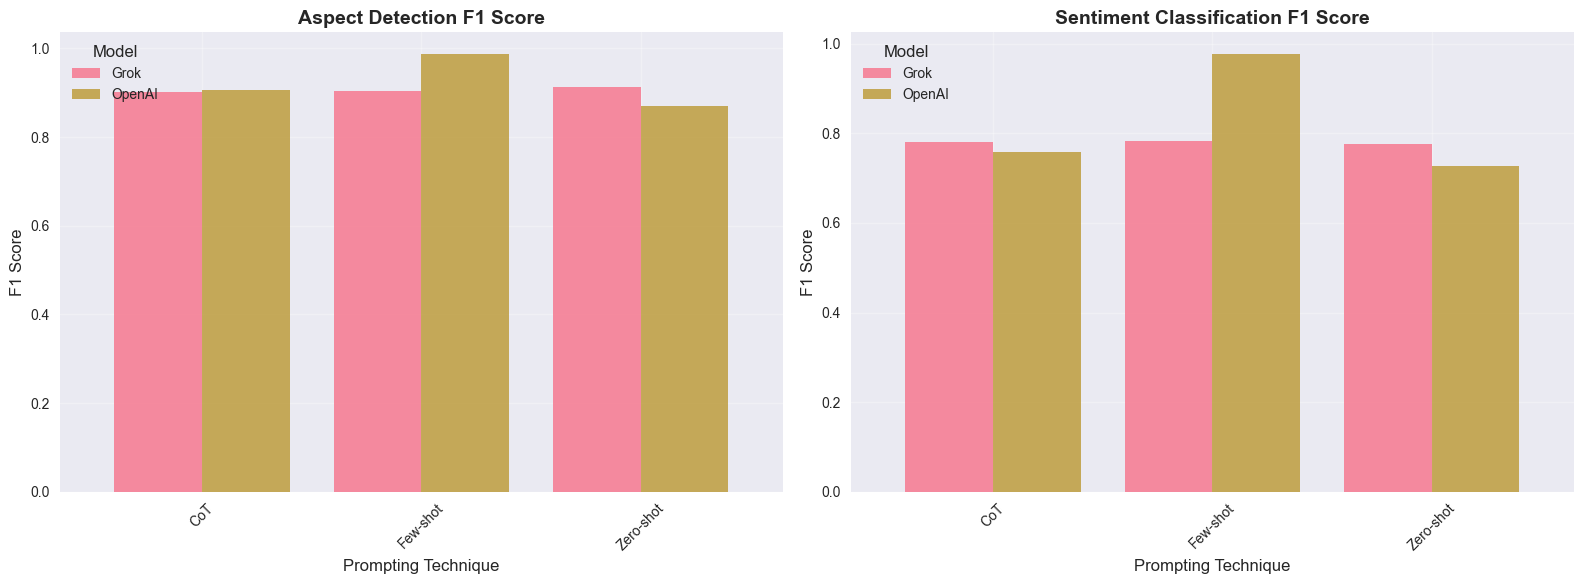

In [20]:
# 1. Biểu đồ so sánh F1 scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Aspect Detection F1
pivot_aspect = results_df.pivot(index='Technique', columns='Model', values='Aspect F1')
pivot_aspect.plot(kind='bar', ax=ax1, width=0.8, alpha=0.8)
ax1.set_title('Aspect Detection F1 Score', fontsize=14, fontweight='bold')
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_xlabel('Prompting Technique', fontsize=12)
ax1.legend(title='Model', loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Sentiment Classification F1  
pivot_sentiment = results_df.pivot(index='Technique', columns='Model', values='Sentiment F1')
pivot_sentiment.plot(kind='bar', ax=ax2, width=0.8, alpha=0.8)
ax2.set_title('Sentiment Classification F1 Score', fontsize=14, fontweight='bold')
ax2.set_ylabel('F1 Score', fontsize=12)
ax2.set_xlabel('Prompting Technique', fontsize=12)
ax2.legend(title='Model', loc='upper left')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

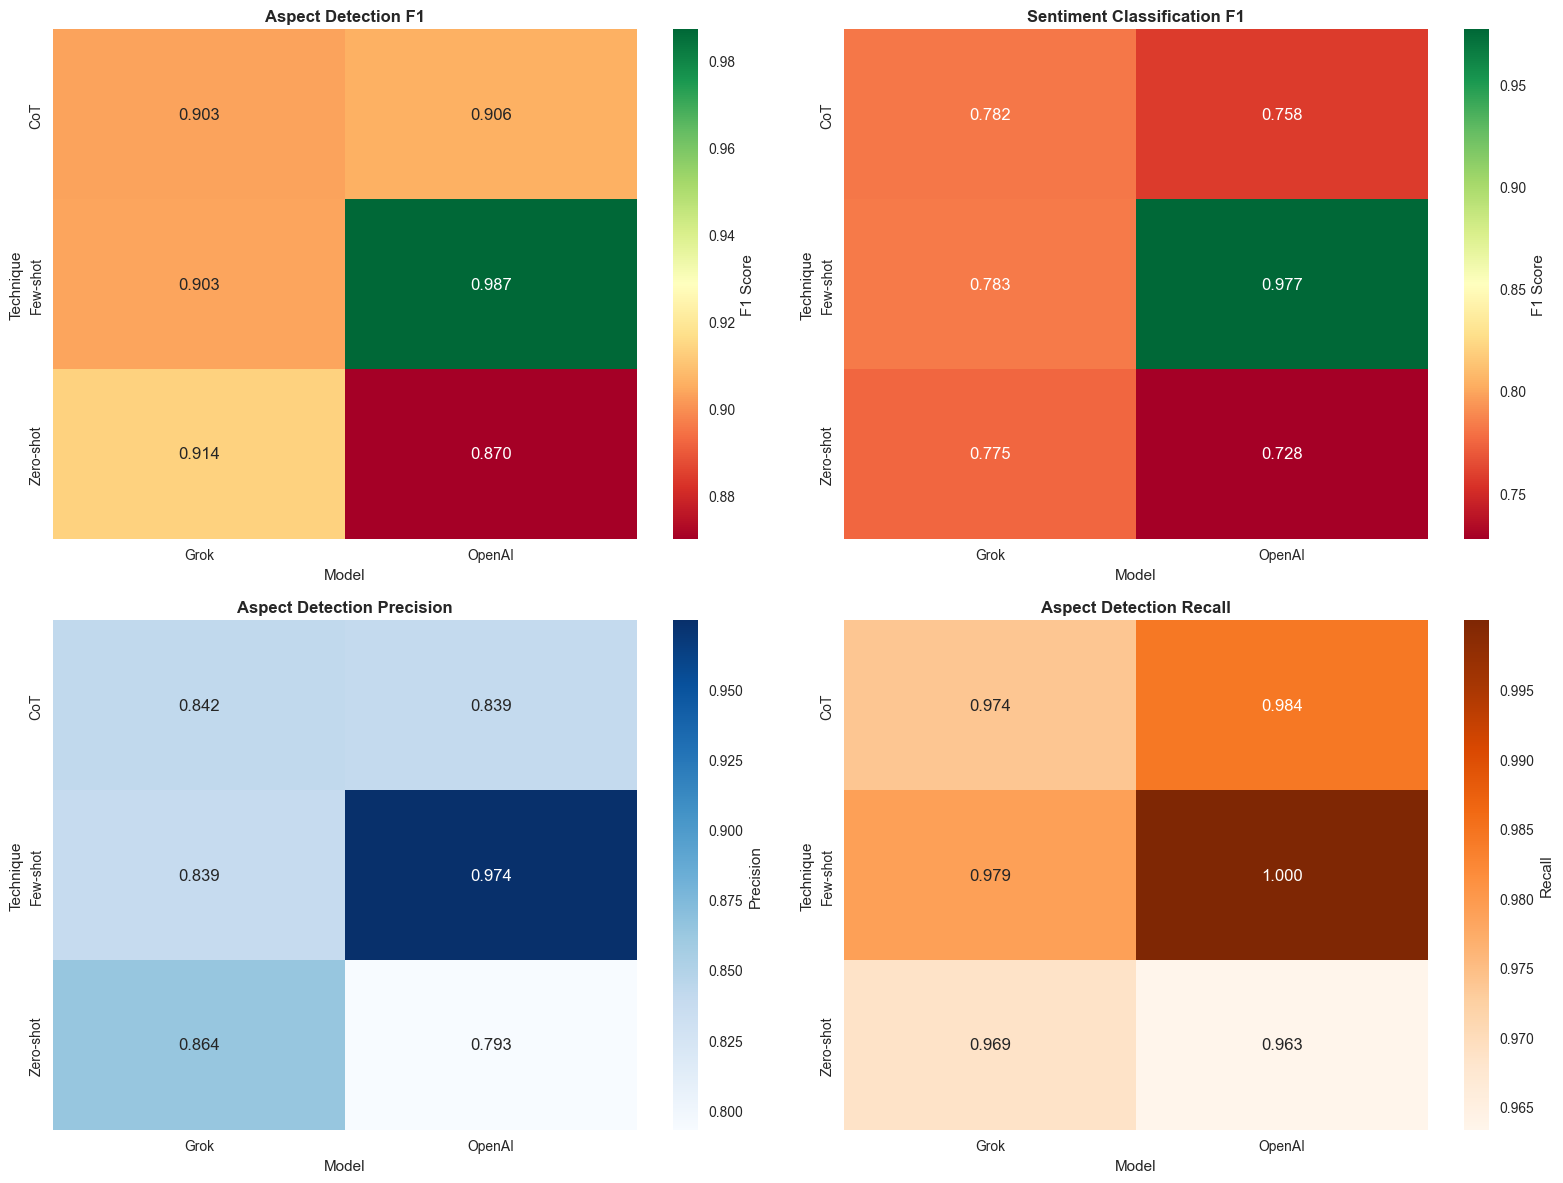

In [21]:
# 2. Heatmap so sánh tổng quan
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Aspect F1
sns.heatmap(pivot_aspect, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=ax1, cbar_kws={'label': 'F1 Score'})
ax1.set_title('Aspect Detection F1', fontweight='bold')

# Sentiment F1
sns.heatmap(pivot_sentiment, annot=True, fmt='.3f', cmap='RdYlGn',
            ax=ax2, cbar_kws={'label': 'F1 Score'})
ax2.set_title('Sentiment Classification F1', fontweight='bold')

# Precision comparison
pivot_precision = results_df.pivot(index='Technique', columns='Model', values='Aspect Precision')
sns.heatmap(pivot_precision, annot=True, fmt='.3f', cmap='Blues',
            ax=ax3, cbar_kws={'label': 'Precision'})
ax3.set_title('Aspect Detection Precision', fontweight='bold')

# Recall comparison
pivot_recall = results_df.pivot(index='Technique', columns='Model', values='Aspect Recall')
sns.heatmap(pivot_recall, annot=True, fmt='.3f', cmap='Oranges',
            ax=ax4, cbar_kws={'label': 'Recall'})
ax4.set_title('Aspect Detection Recall', fontweight='bold')

plt.tight_layout()
plt.show()

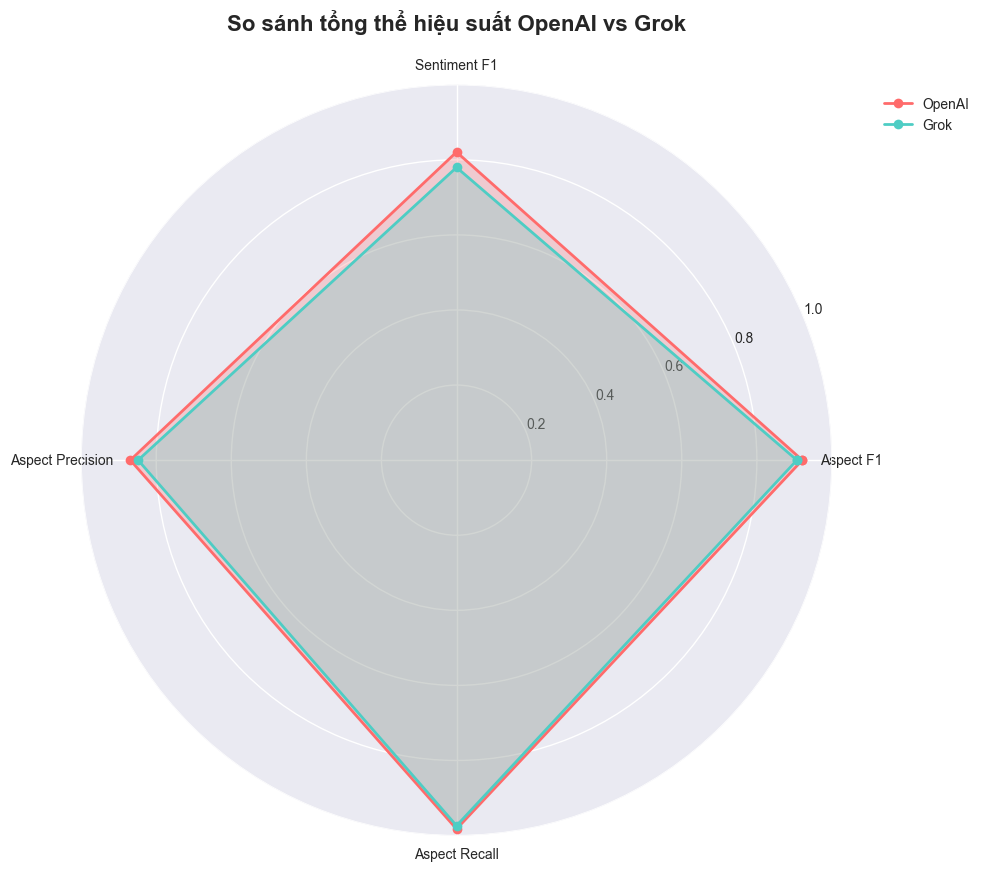

In [22]:
# 3. Radar chart so sánh tổng thể
import math

def create_radar_chart(data, models, metrics, title):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    angles = [n / float(len(metrics)) * 2 * math.pi for n in range(len(metrics))]
    angles += angles[:1]  # Complete the circle
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    
    for i, model in enumerate(models):
        values = [data[data['Model'] == model][metric].mean() for metric in metrics]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
        ax.fill(angles, values, alpha=0.25, color=colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metrics)
    ax.set_ylim(0, 1)
    ax.set_title(title, size=16, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

# Tạo radar chart
metrics = ['Aspect F1', 'Sentiment F1', 'Aspect Precision', 'Aspect Recall']
models = results_df['Model'].unique()

create_radar_chart(results_df, models, metrics, 
                  'So sánh tổng thể hiệu suất OpenAI vs Grok')

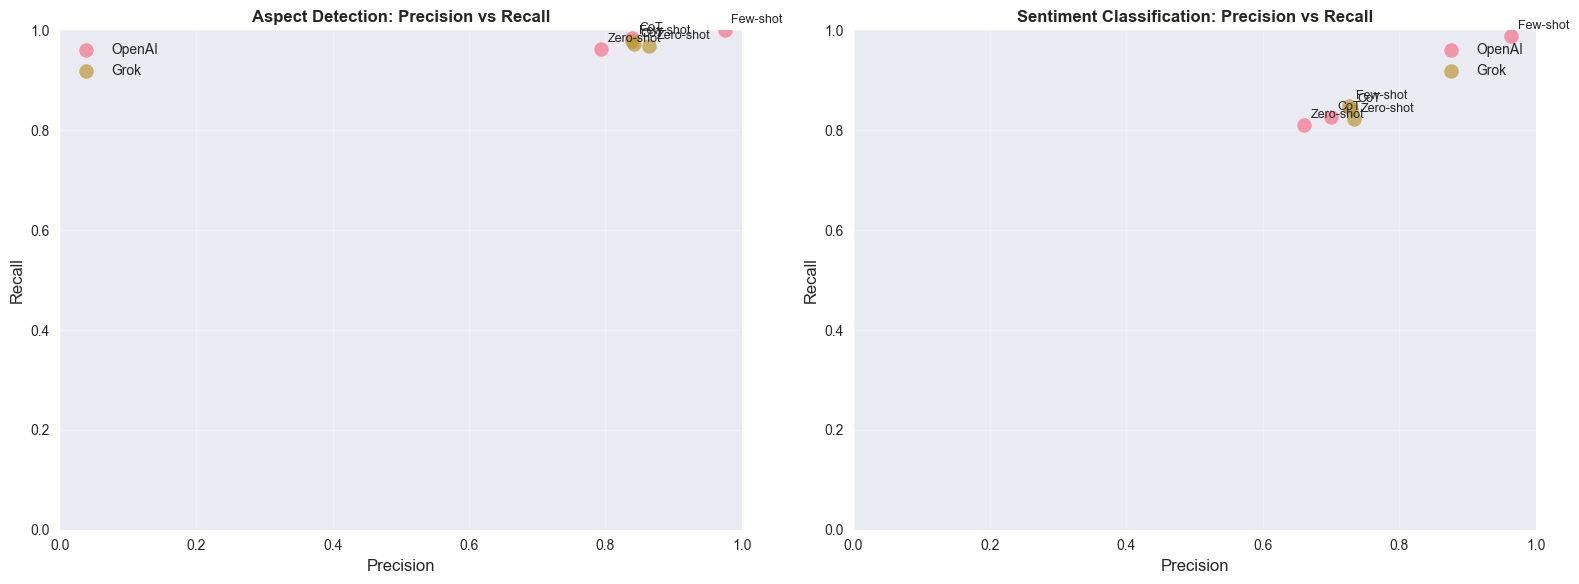

In [23]:
# 4. Biểu đồ scatter plot: Precision vs Recall
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Aspect Detection
for model in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model]
    ax1.scatter(model_data['Aspect Precision'], model_data['Aspect Recall'], 
               label=model, s=100, alpha=0.7)
    
    for i, technique in enumerate(model_data['Technique']):
        ax1.annotate(technique, 
                    (model_data.iloc[i]['Aspect Precision'], 
                     model_data.iloc[i]['Aspect Recall']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax1.set_xlabel('Precision', fontsize=12)
ax1.set_ylabel('Recall', fontsize=12)
ax1.set_title('Aspect Detection: Precision vs Recall', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)

# Sentiment Classification
for model in results_df['Model'].unique():
    model_data = results_df[results_df['Model'] == model]
    ax2.scatter(model_data['Sentiment Precision'], model_data['Sentiment Recall'], 
               label=model, s=100, alpha=0.7)
    
    for i, technique in enumerate(model_data['Technique']):
        ax2.annotate(technique, 
                    (model_data.iloc[i]['Sentiment Precision'], 
                     model_data.iloc[i]['Sentiment Recall']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('Precision', fontsize=12)
ax2.set_ylabel('Recall', fontsize=12)
ax2.set_title('Sentiment Classification: Precision vs Recall', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

## 📈 Bảng so sánh chi tiết

In [24]:
# Tạo bảng so sánh đẹp
comparison_table = results_df.round(3)

print("="*80)
print("🏆 BẢNG SO SÁNH HIỆU SUẤT OPENAI GPT-4o vs GROK")
print("="*80)

# Group by technique để so sánh
for technique in results_df['Technique'].unique():
    technique_data = results_df[results_df['Technique'] == technique]
    print(f"\n📋 {technique}:")
    print("-" * 50)
    
    for _, row in technique_data.iterrows():
        print(f"{row['Model']:8} | Aspect F1: {row['Aspect F1']:.3f} | Sentiment F1: {row['Sentiment F1']:.3f}")

# Tính average scores
print("\n" + "="*80)
print("📊 ĐIỂM TRUNG BÌNH:")
print("="*80)

avg_scores = results_df.groupby('Model')[['Aspect F1', 'Sentiment F1']].mean()
for model in avg_scores.index:
    print(f"{model:8} | Aspect F1: {avg_scores.loc[model, 'Aspect F1']:.3f} | Sentiment F1: {avg_scores.loc[model, 'Sentiment F1']:.3f}")

# Tìm best performer
best_aspect = results_df.loc[results_df['Aspect F1'].idxmax()]
best_sentiment = results_df.loc[results_df['Sentiment F1'].idxmax()]

print("\n" + "="*80)
print("🥇 THÀNH TÍCH TỐT NHẤT:")
print("="*80)
print(f"Aspect Detection: {best_aspect['Model']} - {best_aspect['Technique']} (F1: {best_aspect['Aspect F1']:.3f})")
print(f"Sentiment Classification: {best_sentiment['Model']} - {best_sentiment['Technique']} (F1: {best_sentiment['Sentiment F1']:.3f})")

🏆 BẢNG SO SÁNH HIỆU SUẤT OPENAI GPT-4o vs GROK

📋 Zero-shot:
--------------------------------------------------
OpenAI   | Aspect F1: 0.870 | Sentiment F1: 0.728
Grok     | Aspect F1: 0.914 | Sentiment F1: 0.775

📋 CoT:
--------------------------------------------------
OpenAI   | Aspect F1: 0.906 | Sentiment F1: 0.758
Grok     | Aspect F1: 0.903 | Sentiment F1: 0.782

📋 Few-shot:
--------------------------------------------------
OpenAI   | Aspect F1: 0.987 | Sentiment F1: 0.977
Grok     | Aspect F1: 0.903 | Sentiment F1: 0.783

📊 ĐIỂM TRUNG BÌNH:
Grok     | Aspect F1: 0.907 | Sentiment F1: 0.780
OpenAI   | Aspect F1: 0.921 | Sentiment F1: 0.821

🥇 THÀNH TÍCH TỐT NHẤT:
Aspect Detection: OpenAI - Few-shot (F1: 0.987)
Sentiment Classification: OpenAI - Few-shot (F1: 0.977)


In [25]:
# Hiển thị bảng đầy đủ với styling
import pandas as pd

# Tạo styled table
styled_table = comparison_table.style.format({
    'Aspect F1': '{:.3f}',
    'Sentiment F1': '{:.3f}',
    'Aspect Precision': '{:.3f}',
    'Aspect Recall': '{:.3f}',
    'Sentiment Precision': '{:.3f}',
    'Sentiment Recall': '{:.3f}'
}).background_gradient(subset=['Aspect F1', 'Sentiment F1'], cmap='RdYlGn')

display(styled_table)

,Model,Technique,Aspect F1,Sentiment F1,Aspect Precision,Aspect Recall,Sentiment Precision,Sentiment Recall
0,OpenAI,Zero-shot,0.870,0.728,0.793,0.963,0.660,0.812
1,OpenAI,CoT,0.906,0.758,0.839,0.984,0.699,0.827
2,OpenAI,Few-shot,0.987,0.977,0.974,1.000,0.964,0.990
3,Grok,Zero-shot,0.914,0.775,0.864,0.969,0.734,0.822
4,Grok,CoT,0.903,0.782,0.842,0.974,0.729,0.843
5,Grok,Few-shot,0.903,0.783,0.839,0.979,0.726,0.848


## 💡 Kết luận và Nhận xét

### Nhận xét về hiệu suất:

1. **Aspect Detection**: 
   - So sánh khả năng nhận diện các aspects trong text
   - Model nào có F1 score cao hơn?

2. **Sentiment Classification**:
   - So sánh khả năng phân loại sentiment chính xác
   - Technique nào hiệu quả nhất?

3. **Prompting Techniques**:
   - **Zero-shot**: Baseline performance
   - **Chain-of-Thought**: Có cải thiện reasoning không?
   - **Few-shot**: Có giúp model hiểu better context không?

### Khuyến nghị:
- Model và technique nào nên sử dụng cho production?
- Trade-off giữa cost và performance?
- Cần cải thiện gì cho experiments tương lai?

In [26]:
# Lưu kết quả so sánh
output_file = RESULT_DIR / 'comparison_openai_vs_grok.json'
results_df.to_json(output_file, orient='records', indent=2, force_ascii=False)
print(f"✅ Đã lưu kết quả so sánh tại: {output_file}")

# Lưu summary
summary = {
    "average_scores": avg_scores.to_dict(),
    "best_performers": {
        "aspect_detection": {
            "model": best_aspect['Model'],
            "technique": best_aspect['Technique'],
            "f1_score": float(best_aspect['Aspect F1'])
        },
        "sentiment_classification": {
            "model": best_sentiment['Model'],
            "technique": best_sentiment['Technique'],
            "f1_score": float(best_sentiment['Sentiment F1'])
        }
    }
}

summary_file = RESULT_DIR / 'comparison_summary.json'
with open(summary_file, 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)

print(f"✅ Đã lưu summary tại: {summary_file}")

✅ Đã lưu kết quả so sánh tại: c:\Users\Admin\Python\ABSA_Prompting\results\comparison_openai_vs_grok.json
✅ Đã lưu summary tại: c:\Users\Admin\Python\ABSA_Prompting\results\comparison_summary.json
